> **Tip**: Welcome to the Investigate a Dataset project! You will find tips in quoted sections like this to help organize your approach to your investigation. Once you complete this project, remove these **Tip** sections from your report before submission. First things first, you might want to double-click this Markdown cell and change the title so that it reflects your dataset and investigation.

# Project: TMDb movie data

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 
This file is a list containing various information about the movie (budget, earnings, cast, genre, etc.).

Certain columns, like ‘cast’ and ‘genres’, contain multiple values separated by pipe (|) characters. 

There are some odd characters in the ‘cast’ column. 

The final two columns ending with “_adj” show the budget and revenue of the associated movie in terms of 2010 dollars, accounting for inflation over time.

> **Tip**: In this section of the report, provide a brief introduction to the dataset you've selected/downloaded for analysis. Read through the description available on the homepage-links present [here](https://docs.google.com/document/d/e/2PACX-1vTlVmknRRnfy_4eTrjw5hYGaiQim5ctr9naaRd4V9du2B5bxpd8FEH3KtDgp8qVekw7Cj1GLk1IXdZi/pub?embedded=True). List all column names in each table, and their significance. In case of multiple tables, describe the relationship between tables. 


### Question(s) for Analysis
①Which genres of movies have been released the most ?

②What are the Top 10 movies based on revenue ?

>**Tip**: Clearly state one or more questions that you plan on exploring over the course of the report. You will address these questions in the **data analysis** and **conclusion** sections. Try to build your report around the analysis of at least one dependent variable and three independent variables. If you're not sure what questions to ask, then make sure you familiarize yourself with the dataset, its variables and the dataset context for ideas of what to explore.

> **Tip**: Once you start coding, use NumPy arrays, Pandas Series, and DataFrames where appropriate rather than Python lists and dictionaries. Also, **use good coding practices**, such as, define and use functions to avoid repetitive code. Use appropriate comments within the code cells, explanation in the mark-down cells, and meaningful variable names. 

In [47]:
# Use this cell to set up import statements for all of the packages that you
#   plan to use.

# Remember to include a 'magic word' so that your visualizations are plotted
#   inline with the notebook. See this page for more:
#   http://ipython.readthedocs.io/en/stable/interactive/magics.html

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

%matplotlib inline

In [48]:
# Upgrade pandas to use dataframe.explode() function. 
!pip install --upgrade pandas==0.25.0

Requirement already up-to-date: pandas==0.25.0 in /opt/conda/lib/python3.6/site-packages (0.25.0)


<a id='wrangling'></a>
## Data Wrangling

> **Tip**: In this section of the report, you will load in the data, check for cleanliness, and then trim and clean your dataset for analysis. Make sure that you **document your data cleaning steps in mark-down cells precisely and justify your cleaning decisions.**


### General Properties
> **Tip**: You should _not_ perform too many operations in each cell. Create cells freely to explore your data. One option that you can take with this project is to do a lot of explorations in an initial notebook. These don't have to be organized, but make sure you use enough comments to understand the purpose of each code cell. Then, after you're done with your analysis, create a duplicate notebook where you will trim the excess and organize your steps so that you have a flowing, cohesive report.

In [49]:
# Load your data and print out a few lines. Perform operations to inspect data
#   types and look for instances of missing or possibly errant data.
df = pd.read_csv('./Database_TMDb_movie_data/tmdb-movies.csv')
df.head(10)


TypeError: __init__() got an unexpected keyword argument 'max_rows'

       id    imdb_id  popularity     budget     revenue  \
0  135397  tt0369610   32.985763  150000000  1513528810   
1   76341  tt1392190   28.419936  150000000   378436354   
2  262500  tt2908446   13.112507  110000000   295238201   
3  140607  tt2488496   11.173104  200000000  2068178225   
4  168259  tt2820852    9.335014  190000000  1506249360   
5  281957  tt1663202    9.110700  135000000   532950503   
6   87101  tt1340138    8.654359  155000000   440603537   
7  286217  tt3659388    7.667400  108000000   595380321   
8  211672  tt2293640    7.404165   74000000  1156730962   
9  150540  tt2096673    6.326804  175000000   853708609   

                 original_title  \
0                Jurassic World   
1            Mad Max: Fury Road   
2                     Insurgent   
3  Star Wars: The Force Awakens   
4                     Furious 7   
5                  The Revenant   
6            Terminator Genisys   
7                   The Martian   
8                       Minions   


In [50]:
df.shape

(10866, 21)

In [51]:
df.duplicated().sum()

1

In [52]:
df.drop_duplicates(inplace = True)

In [53]:
df.describe()

TypeError: __init__() got an unexpected keyword argument 'max_rows'

                  id    popularity        budget       revenue       runtime  \
count   10865.000000  10865.000000  1.086500e+04  1.086500e+04  10865.000000   
mean    66066.374413      0.646446  1.462429e+07  3.982690e+07    102.071790   
std     92134.091971      1.000231  3.091428e+07  1.170083e+08     31.382701   
min         5.000000      0.000065  0.000000e+00  0.000000e+00      0.000000   
25%     10596.000000      0.207575  0.000000e+00  0.000000e+00     90.000000   
50%     20662.000000      0.383831  0.000000e+00  0.000000e+00     99.000000   
75%     75612.000000      0.713857  1.500000e+07  2.400000e+07    111.000000   
max    417859.000000     32.985763  4.250000e+08  2.781506e+09    900.000000   

         vote_count  vote_average  release_year    budget_adj   revenue_adj  
count  10865.000000  10865.000000  10865.000000  1.086500e+04  1.086500e+04  
mean     217.399632      5.975012   2001.321859  1.754989e+07  5.136900e+07  
std      575.644627      0.935138     12.8132

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10865 entries, 0 to 10865
Data columns (total 21 columns):
id                      10865 non-null int64
imdb_id                 10855 non-null object
popularity              10865 non-null float64
budget                  10865 non-null int64
revenue                 10865 non-null int64
original_title          10865 non-null object
cast                    10789 non-null object
homepage                2936 non-null object
director                10821 non-null object
tagline                 8041 non-null object
keywords                9372 non-null object
overview                10861 non-null object
runtime                 10865 non-null int64
genres                  10842 non-null object
production_companies    9835 non-null object
release_date            10865 non-null object
vote_count              10865 non-null int64
vote_average            10865 non-null float64
release_year            10865 non-null int64
budget_adj              1

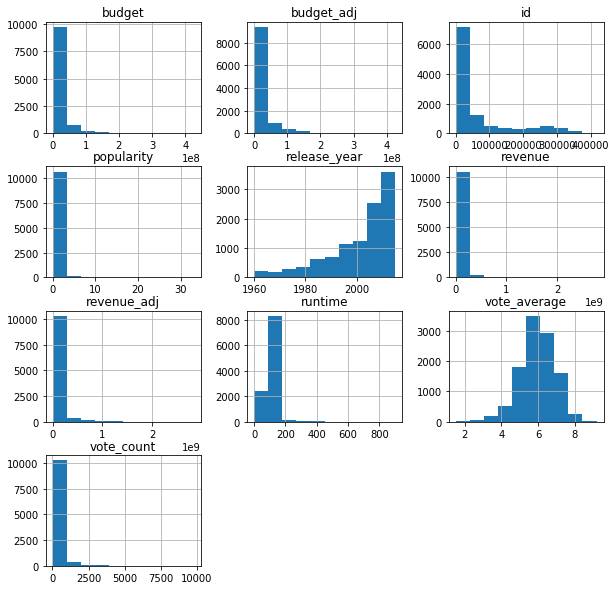

In [55]:
data.hist(figsize = (10, 10));


### Data Cleaning
> **Tip**: Make sure that you keep your reader informed on the steps that you are taking in your investigation. Follow every code cell, or every set of related code cells, with a markdown cell to describe to the reader what was found in the preceding cell(s). Try to make it so that the reader can then understand what they will be seeing in the following cell(s).
 

In [56]:
# After discussing the structure of the data and any problems that need to be
#   cleaned, perform those cleaning steps in the second part of this section.

df.drop(['id', 'imdb_id', 'popularity', 'original_title', 'cast', 'homepage', 'director', 'tagline', 'keywords', 'overview', 'runtime', 'production_companies', 'release_date', 'vote_count'], axis = 1, inplace = True)


In [57]:
###Search for any missing information, like missing genre fields.
###23 movies are missing genre information, so given the size of the dataset, I remove these movies from the dataset for this analysis.

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10865 entries, 0 to 10865
Data columns (total 7 columns):
budget          10865 non-null int64
revenue         10865 non-null int64
genres          10842 non-null object
vote_average    10865 non-null float64
release_year    10865 non-null int64
budget_adj      10865 non-null float64
revenue_adj     10865 non-null float64
dtypes: float64(3), int64(3), object(1)
memory usage: 679.1+ KB


In [59]:
df.dropna(axis = 0, inplace = True, subset = ['genres'])

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10842 entries, 0 to 10865
Data columns (total 7 columns):
budget          10842 non-null int64
revenue         10842 non-null int64
genres          10842 non-null object
vote_average    10842 non-null float64
release_year    10842 non-null int64
budget_adj      10842 non-null float64
revenue_adj     10842 non-null float64
dtypes: float64(3), int64(3), object(1)
memory usage: 677.6+ KB


<a id='eda'></a>
## Exploratory Data Analysis

> **Tip**: Now that you've trimmed and cleaned your data, you're ready to move on to exploration. **Compute statistics** and **create visualizations** with the goal of addressing the research questions that you posed in the Introduction section. You should compute the relevant statistics throughout the analysis when an inference is made about the data. Note that at least two or more kinds of plots should be created as part of the exploration, and you must  compare and show trends in the varied visualizations. 



> **Tip**: - Investigate the stated question(s) from multiple angles. It is recommended that you be systematic with your approach. Look at one variable at a time, and then follow it up by looking at relationships between variables. You should explore at least three variables in relation to the primary question. This can be an exploratory relationship between three variables of interest, or looking at how two independent variables relate to a single dependent variable of interest. Lastly, you  should perform both single-variable (1d) and multiple-variable (2d) explorations.


### Research Question 1 (①Which genres of movies have been released the most ?)

In [61]:
# Use this, and more code cells, to explore your data. Don't forget to add
#   Markdown cells to document your observations and findings.
df.genres.nunique()

2039

In [62]:
genre_array = df.genres.values
genre_array = genre_array.astype('U')
print(genre_array.dtype)

<U51


In [63]:
split_genre_array = np.core.defchararray.split(a = genre_array, sep = '|')

In [64]:
print(split_genre_array.dtype)
print(split_genre_array)

object
[['Action', 'Adventure', 'Science Fiction', 'Thriller']
 ['Action', 'Adventure', 'Science Fiction', 'Thriller']
 ['Adventure', 'Science Fiction', 'Thriller'] ..., ['Mystery', 'Comedy']
 ['Action', 'Comedy'] ['Horror']]


In [65]:
total_words = 0
max_length = 0

for index, row in enumerate(split_genre_array):
    for word in split_genre_array[index]:
        total_words += 1
        if len(word) > max_length:
            max_length = len(word)
        
print('total_words: ' + str(total_words))
print('max_length: ' + str(max_length))

total_words: 26955
max_length: 15


In [66]:
combined_genre_array = np.empty((1, total_words), dtype = ('U' + str(max_length)))
combined_genre_array.shape

(1, 26955)

In [67]:
count = 0

for index, row in enumerate(split_genre_array):
    row_list = ast.literal_eval(str(row))
    
    for word in row_list:
        combined_genre_array[0, count] = word
        count += 1
        

In [68]:
print(combined_genre_array)

[['Action' 'Adventure' 'Science Fiction' ..., 'Action' 'Comedy' 'Horror']]


In [69]:
genre_list = np.unique(combined_genre_array)
print(genre_list)

['Action' 'Adventure' 'Animation' 'Comedy' 'Crime' 'Documentary' 'Drama'
 'Family' 'Fantasy' 'Foreign' 'History' 'Horror' 'Music' 'Mystery'
 'Romance' 'Science Fiction' 'TV Movie' 'Thriller' 'War' 'Western']


In [71]:
#_df = df.loc[df.genres.str.contains('')]
action_df = df.loc[df.genres.str.contains('Action')]
adventure_df = df.loc[df.genres.str.contains('Adventure')]
animation_df = df.loc[df.genres.str.contains('Animation')]
comedy_df = df.loc[df.genres.str.contains('Comedy')]
crime_df = df.loc[df.genres.str.contains('Crime')]
documentary_df = df.loc[df.genres.str.contains('Documentary')]
drama_df = df.loc[df.genres.str.contains('Drama')]
family_df = df.loc[df.genres.str.contains('Family')]
fantasy_df = df.loc[df.genres.str.contains('Fantasy')]
foreign_df = df.loc[df.genres.str.contains('Foreign')]
history_df = df.loc[df.genres.str.contains('History')]
horror_df = df.loc[df.genres.str.contains('Horror')]
music_df = df.loc[df.genres.str.contains('Music')]
mystery_df = df.loc[df.genres.str.contains('Mystery')]
romance_df = df.loc[df.genres.str.contains('Romance')]
science_fiction_df = df.loc[df.genres.str.contains('Science Fiction')]
tv_movie_df = df.loc[df.genres.str.contains('TV Movie')]
thriller_df = df.loc[df.genres.str.contains('Thriller')]
war_df = df.loc[df.genres.str.contains('War')]
western_df = df.loc[df.genres.str.contains('Western')]

In [72]:
genre_count = []
for genre in genre_list:
    temp = genre.lower() + "_df"
    temp = temp.replace(" ", "_")
    number = len(eval(temp + '.index'))
    
    genre_count.append([temp[:-3], number])
    
genre_count.sort(key = lambda x:x[1], reverse = True)

for index, genre in enumerate(genre_count):
    genre_count[index] = [genre[0].title().replace("_", " "), genre[1]]

print(genre_count)

[['Drama', 4760], ['Comedy', 3793], ['Thriller', 2907], ['Action', 2384], ['Romance', 1712], ['Horror', 1637], ['Adventure', 1471], ['Crime', 1354], ['Family', 1231], ['Science Fiction', 1229], ['Fantasy', 916], ['Mystery', 810], ['Animation', 699], ['Documentary', 520], ['Music', 408], ['History', 334], ['War', 270], ['Foreign', 188], ['Tv Movie', 167], ['Western', 165]]


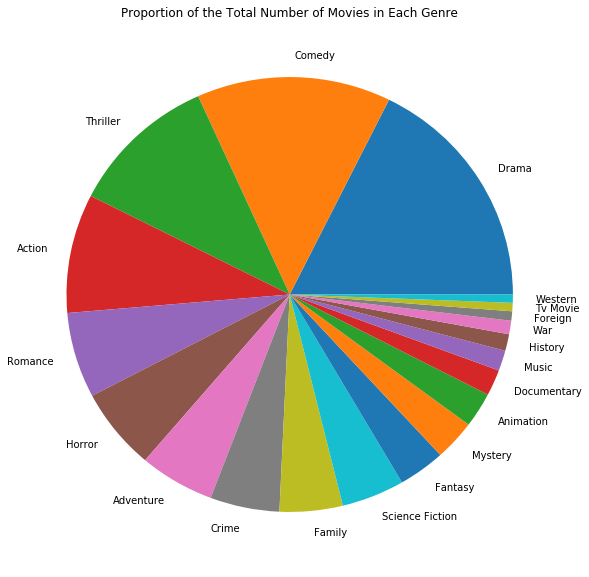

In [74]:
genre, amount = [*zip(*genre_count)]
plt.figure(figsize = (10, 10))
plt.title('Proportion of the Total Number of Movies in Each Genre')
plt.pie(amount, labels = genre, textprops = {'fontsize': 10})

plt.show()

### Research Question 2  (②What are the Top 10 movies based on revenue?)

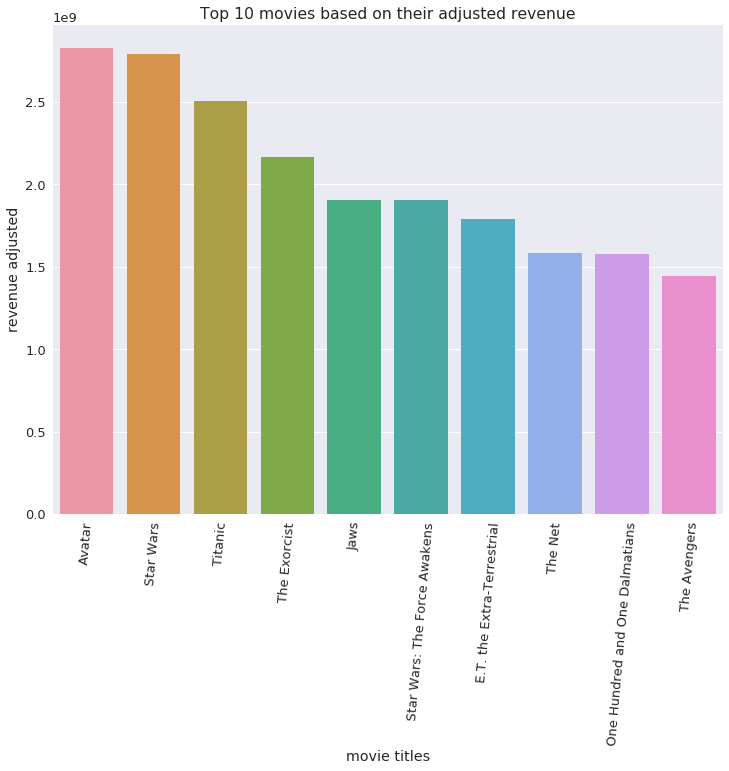

In [77]:
# Continue to explore the data to address your additional research
#   questions. Add more headers as needed if you have more questions to
#   investigate.
###
#Top Movies based on different features
###

revenue_dict = {}

#fetching different columns with 2 different ways of code
movies_and_revenue = data[["original_title", "revenue_adj"]]
movies_and_budget = data[['original_title','budget_adj']]
movies_and_popularity = data[['original_title','popularity']]
movies_and_votes= data[['original_title','vote_average']]


#print(movies_and_revenue.sort_values(by="revenue_adj", ascending=False).head(10))
#print("\n")
#print(movies_and_budget.sort_values(by = "budget_adj", ascending = False).head(10))

sns.set(rc={'figure.figsize':(12,9)}, font_scale=1.3)


ax = sns.barplot(
    movies_and_revenue.sort_values(by = "revenue_adj", ascending=False).head(10).original_title, 
    movies_and_revenue.sort_values(by = "revenue_adj", ascending=False).head(10).revenue_adj)



#rotate x-axis' text
for item in ax.get_xticklabels():
    item.set_rotation(85)
    

ax.set(xlabel='movie titles', ylabel='revenue adjusted', title = 'Top 10 movies based on their adjusted revenue')
plt.show()

<a id='conclusions'></a>
## Conclusions
■From above chart, it is easy to see which genres have the most movies. The top three genres are Drama, Comedy, and Thriller.

■According to the table above, the top 5 movies from the given dataset based on their adjusted revenue are the followings; Avatar, Star Wars, Titanic, The Exorcist and Jaws.

> **Tip**: Finally, summarize your findings and the results that have been performed in relation to the question(s) provided at the beginning of the analysis. Summarize the results accurately, and point out where additional research can be done or where additional information could be useful.

> **Tip**: Make sure that you are clear with regards to the limitations of your exploration. You should have at least 1 limitation explained clearly. 

> **Tip**: If you haven't done any statistical tests, do not imply any statistical conclusions. And make sure you avoid implying causation from correlation!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.

## Submitting your Project 

> **Tip**: Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> **Tip**: Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> **Tip**: Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [79]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0